## Part 2 of the LIFE SCIENCE DATA SCIENTIST RECRUITMENT TASK

Author: Liubov Shilova

Date: 16.01.2023

Code tested on Keras: 2.9.0

The current notebook presents code used for training and testing an LSTM model for asthma attack prediction.

In [4]:
import pandas as pd
import numpy as np
import warnings
import pickle
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.layers import Activation, Conv1D, Embedding, GlobalAveragePooling1D

from keras.callbacks import EarlyStopping

plt.style.use('ggplot')
%matplotlib inline

model_path = './asthma_attack_prediction.h5'

np.random.seed(42)  

## Functions

In [2]:
def find_label(frame):
  """
  Finds the target value of a frame by checking the last value of column 'Days_Until_Attack'.
  """
  if frame['Days_Until_Attack'].iloc[-1] <= 2:
    return 1
  else:
    return 0

def choose_columns(frame):
  """
  Slice only needed columns from a frame.
  """

  selected_cols = ['Gender', 'Age', 'Smoke', 'Height_Cm', 'PEF', 'FEV1', 'FVC']
  
  return frame[selected_cols].reset_index(drop = True).to_numpy()

In [3]:
def split_into_period_frames(prediction_period, df):
  """
  Split training data into frames of prediction_period length
  """

  split_frames = np.array_split(df, df.shape[0]/prediction_period)
  y = [find_label(frame) for frame in split_frames]

  X_frames = [choose_columns(frame) for frame in split_frames]
  X_frames = np.array(X_frames)

  return (X_frames, y)

In [4]:
def add_cases(prediction_period, df, X_frames, y):
  """
  Add positive cases to training frames: 
  for each attack take the period of prediction_period before the attack
  """

  attack_indexes = df[df["Attack_Day"] > prediction_period].index
  for ind in attack_indexes:
    start_measuring_ind = ind - prediction_period
    selected_features = ['Gender', 'Age', 'Smoke', 'Height_Cm', 'PEF', 'FEV1', 'FVC']
    feature_frame = df.iloc[start_measuring_ind:ind][selected_features].reset_index(drop = True).to_numpy()
    feature_frame = np.expand_dims(feature_frame, axis = 0)
    X_frames = np.vstack((X_frames, feature_frame))
    y.append(1)

  return(X_frames, y)  

In [29]:
def plot_history(history, path_to_save):
  """
  Plots the history of a model and saves the plots.
  """

  font = {'size':'22', 'color':'black', 'weight':'normal'}

  # Plot AUC history
  fig_auc = plt.figure(figsize=(20, 5), dpi=100)
  plt.subplot(1, 2, 1)
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
  plt.title('AUC')
  plt.xlabel('Epoch', **font)
  plt.ylabel('AUC', **font)
  plt.ylim((0.6, 1.05))
  plt.xlim((0, 15))
  plt.plot(history.history['auc'], label = 'training',  linewidth = 3)
  plt.plot(history.history['val_auc'], label = 'validation',  linewidth = 3)
  plt.legend(['training', 'validation'], loc = 'lower right', prop = {'size': 20})

  # Plot loss history
  plt.subplot(1, 2, 2)
  plt.title('Loss')
  plt.xlabel('Epoch', **font)
  plt.ylabel('Loss', **font)
  plt.ylim((0, 0.7))
  plt.xlim((0, 15))
  plt.plot(history.history['loss'], label = 'training',  linewidth = 3)
  plt.plot(history.history['val_loss'], label = 'validation',  linewidth = 3)
  plt.legend(['training', 'validation'], loc = 'upper right', prop={'size': 20})

  fig_auc.savefig(path_to_save)

## Data preprocessing

In [6]:
#Load the data
df = pd.read_csv("lsds_recruiting_task_inputdata.csv")

In [7]:
#See how many attacks per patient is there
attacks_per_patient = df.groupby('Patient_ID').AsthmaAttack.sum()
print(f"There are {len(attacks_per_patient[attacks_per_patient > 0])} patients, who had at least one attack during the trial.")
print(f"Number of attacks per patient varies from {attacks_per_patient.min()} to {attacks_per_patient.max()}.")

There are 73 patients, who had at least one attack during the trial.
Number of attacks per patient varies from 0 to 4.


In [8]:
#Separate the dataset needed for training the model in task 2
df2 = df[['Patient_ID', 'Gender', 'Age', 'Smoke', 'Height_Cm', 'PEF', 'FEV1', 'FVC', 'Day_ID', 'AsthmaAttack']].copy()

In [9]:
#Encode the categorical values 
smoke_mapping = {'No':0,'Yes':1}
gender_mapping = {'Male':0,'Female':1}

df2['Smoke'] = df2['Smoke'].map(smoke_mapping)
df2['Gender'] = df2['Gender'].map(gender_mapping)

In [10]:
#Create a separate column with attack days for each patient
df2['Attack_Day'] = df2[df2['AsthmaAttack'] == 1]['Day_ID'].reindex(list(range(df2.index.min(),df2.index.max()+1)),fill_value=np.NaN)

In [11]:
#Create a separate column with an ID of a nearest attack day
df2['Nearest_Attack_Day'] = df2.groupby('Patient_ID').Attack_Day.apply(lambda x: x.fillna(method='bfill'))

In [12]:
#Create an additional column with days until the nearest attack
df2['Days_Until_Attack'] = df2['Nearest_Attack_Day'] - df2['Day_ID']

In [13]:
#Split the patients into train and test set
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 42)
split = splitter.split(df2, groups=df['Patient_ID'])
train_inds, test_inds = next(split)

train = df2.iloc[train_inds].reset_index(drop=True)
test = df2.iloc[test_inds].reset_index(drop=True)

In [14]:
#Scale the numerical variables
to_scale = ['Gender', 'Age', 'Smoke', 'Height_Cm', 'PEF', 'FEV1', 'FVC']

scaler = preprocessing.MinMaxScaler()

scaler.fit(train[to_scale])

train[to_scale] = scaler.transform(train[to_scale])
test[to_scale] = scaler.transform(test[to_scale])

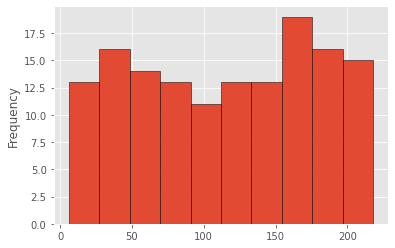

In [15]:
#See on which days the attacks tipically occured
train['Attack_Day'].plot(kind='hist', edgecolor='black')

In [16]:
#Choose the period used for prediction, has to be 224%prediction_period == 0
prediction_period = 7 

if 224%prediction_period != 0:
  warnings.warn("For this prediction period you have to rewrite the frame splitting process to guarantee the frame includs data from only one patient!")

In [17]:
#Preparing the train set with dimentions (cases, time, features)
X_train, y_train = split_into_period_frames(prediction_period, train)
print(f"""After spliting:
The training data includes {len(y_train)} frames, 
among which {sum(y_train)} are positive
""")
X_train, y_train = add_cases(prediction_period, train, X_train, y_train)
print(f"""After adding positive samples:
The training data includes {len(y_train)} frames, 
among which {sum(y_train)} are positive
""")

print(f"In the training set there are {round( (len(y_train)-sum(y_train)) / sum(y_train), 2)} times more negative samples than positive ones.")

After spliting:
The training data includes 6752 frames, 
among which 62 are positive

After adding positive samples:
The training data includes 6893 frames, 
among which 203 are positive

In the training set there are 32.96 times more negative samples than positive ones.


In [18]:
class_weight = {0: 1., 1: 30.}

## Training and evaluating models

In [19]:
y_train = np.array(y_train)
features_number = X_train.shape[2]

In [22]:
####################CREATE 1st LSTM MODEL#######################################
model1 = Sequential()

model1.add(LSTM(
         input_shape=(prediction_period, features_number),
         units=100,
         return_sequences=True))

model1.add(Dropout(0.2))

model1.add(LSTM(
          units=50,
          return_sequences=False))

model1.add(Dropout(0.2))

model1.add(Dense(units=1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['MeanSquaredError', 'AUC'])

model1.summary()

#################FIT THE MODEL##################################################

history1 = model1.fit(X_train, y_train, epochs=15, batch_size=10, 
                    validation_split=0.2, verbose=2, class_weight=class_weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0, 
                                                     patience=10, 
                                                     verbose=0, 
                                                     mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, 
                                                       monitor='val_loss', 
                                                       save_best_only=True, 
                                                       mode='min', 
                                                       verbose=0)]
          )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 100)            43200     
                                                                 
 dropout_2 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 73,451
Trainable params: 73,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
552/552 - 12s - loss: 0.6855 - mean_squ

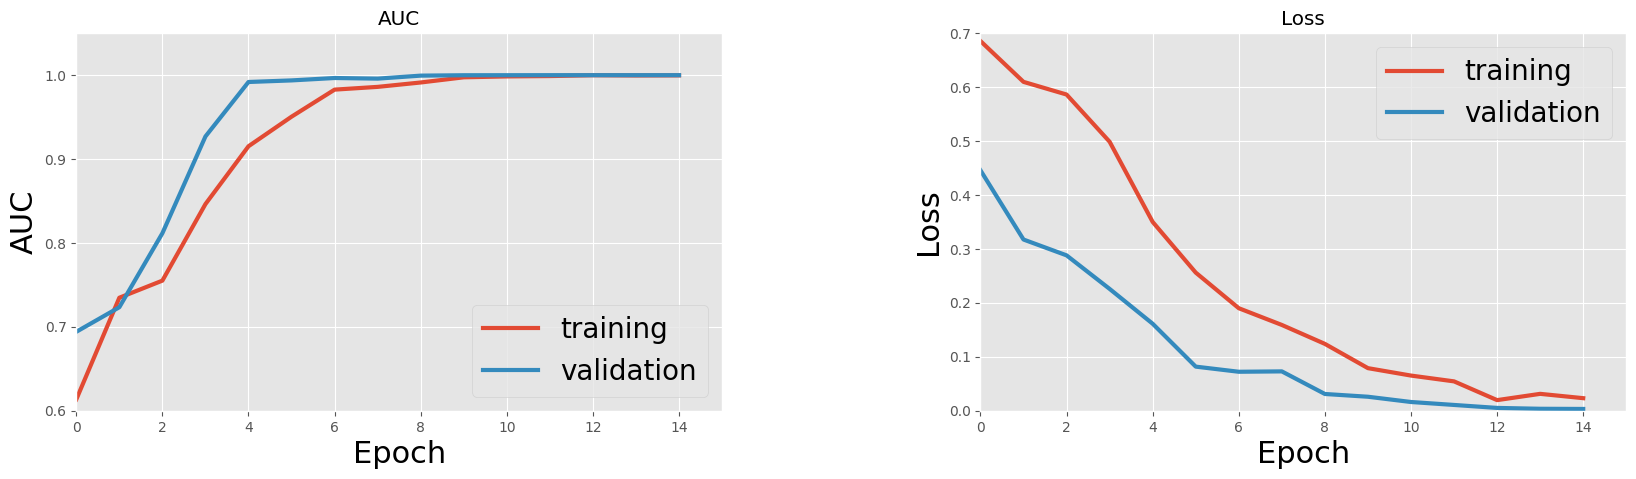

In [30]:
plot_history(history1, "LSTM_100_model_loss.png")

In [31]:
####################CREATE 2nd LSTM MODEL#######################################
model2 = Sequential()

model2.add(LSTM(
         input_shape=(prediction_period, features_number),
         units=70,
         return_sequences=True))

model2.add(Dropout(0.2))

model2.add(LSTM(
          units=35,
          return_sequences=False))

model2.add(Dropout(0.2))

model2.add(Dense(units=1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['MeanSquaredError', 'AUC'])

model2.summary()

#################FIT THE MODEL##################################################

history2 = model2.fit(X_train, y_train, epochs=15, batch_size=10, 
                    validation_split=0.2, verbose=2, class_weight=class_weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0, 
                                                     patience=10, 
                                                     verbose=0, 
                                                     mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, 
                                                       monitor='val_loss', 
                                                       save_best_only=True, 
                                                       mode='min', 
                                                       verbose=0)]
          )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 70)             21840     
                                                                 
 dropout_4 (Dropout)         (None, 7, 70)             0         
                                                                 
 lstm_5 (LSTM)               (None, 35)                14840     
                                                                 
 dropout_5 (Dropout)         (None, 35)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 36        
                                                                 
Total params: 36,716
Trainable params: 36,716
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
552/552 - 12s - loss: 0.6848 - mean_squ

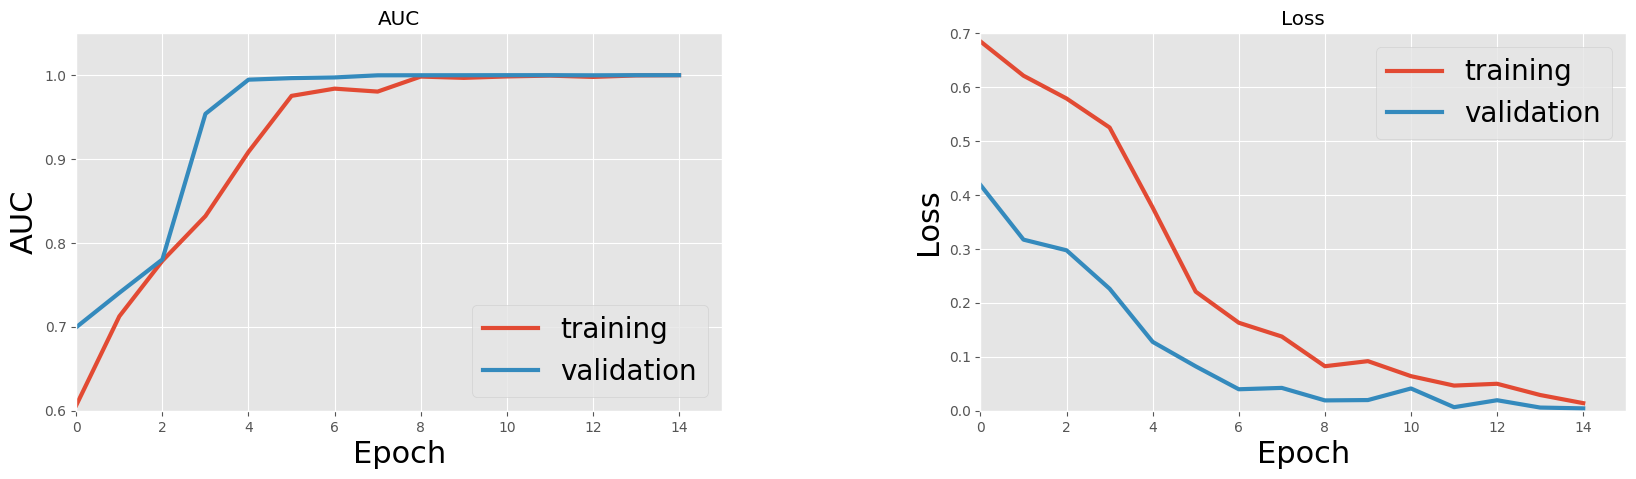

In [32]:
plot_history(history2, "LSTM_70_model_loss.png")

In [33]:
####################CREATE GRU MODEL############################################
model3 = Sequential()

model3.add(GRU(
         input_shape=(prediction_period, features_number),
         units=100,
         return_sequences=True))

model3.add(Dropout(0.2))

model3.add(GRU(
          units=50,
          return_sequences=False))

model3.add(Dropout(0.2))

model3.add(Dense(units=1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['MeanSquaredError', 'AUC'])

model3.summary()

#################FIT THE MODEL##################################################

history3 = model3.fit(X_train, y_train, epochs=9, batch_size=10, 
                    validation_split=0.2, verbose=2, class_weight=class_weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0, 
                                                     patience=10, 
                                                     verbose=0, 
                                                     mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, 
                                                       monitor='val_loss', 
                                                       save_best_only=True, 
                                                       mode='min', 
                                                       verbose=0)]
          )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 100)            32700     
                                                                 
 dropout_6 (Dropout)         (None, 7, 100)            0         
                                                                 
 gru_1 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 55,551
Trainable params: 55,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/9
552/552 - 13s - loss: 0.6058 - mean_squa

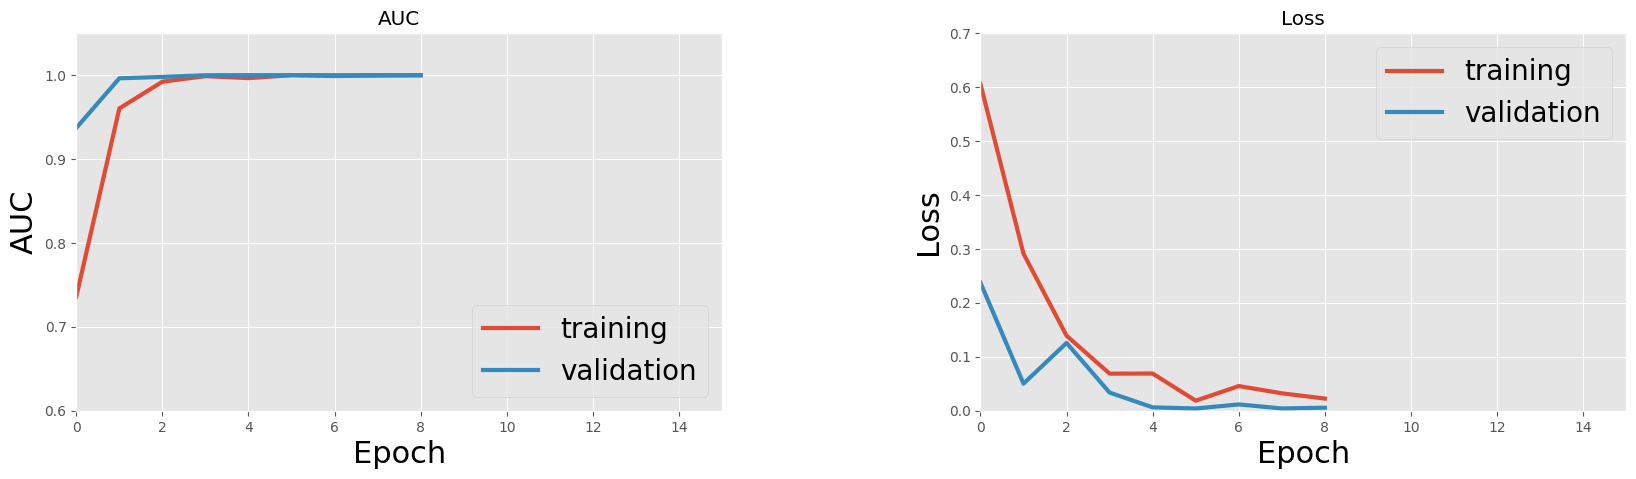

In [34]:
plot_history(history3, "GRU_100_model_loss.png")

In [35]:
####################CREATE 1D CNN MODEL#########################################


model4 = Sequential()

model4.add(Conv1D(filters=100, kernel_size=3, activation='relu', 
                  input_shape=(prediction_period, features_number)))
model4.add(Conv1D(filters=50, kernel_size=3, activation='relu'))
model4.add(GlobalAveragePooling1D())
model4.add(Dropout(0.2))

model4.add(Dense(units=1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['MeanSquaredError', 'AUC'])

model4.summary()

#################FIT THE MODEL##################################################

history4 = model4.fit(X_train, y_train, epochs=15, batch_size=10, 
                    validation_split=0.2, verbose=2, class_weight=class_weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0, 
                                                     patience=10, 
                                                     verbose=0, 
                                                     mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, 
                                                       monitor='val_loss', 
                                                       save_best_only=True, 
                                                       mode='min', 
                                                       verbose=0)]
          )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 100)            2200      
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 50)             15050     
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 17,301
Trainable params: 17,301
Non-trainable params: 0
__________________________________________________

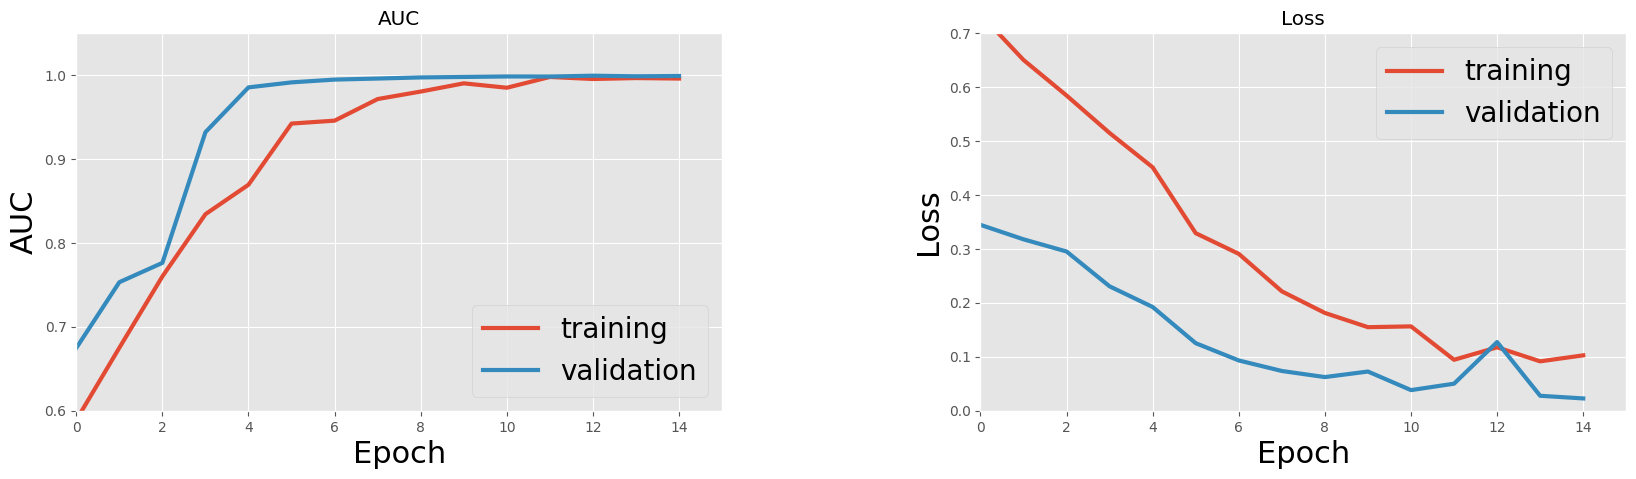

In [36]:
plot_history(history4, "CNN_model_loss.png")

In [37]:
############################SAVE THE MODEL######################################
f_name = open("GRU_asthma_attack_1_week","wb")
pickle.dump(history3, f_name)
f_name.close()
        
# save JSON
model_json = model3.to_json()
with open("GRU_asthma_attack_1_week.json", "w") as json_file:
    json_file.write(model_json)

# save HDF5
model3.save_weights("GRU_asthma_attack_1_week.h5")
print("Model saved as GRU_asthma_attack_1_week")

Model saved as GRU_asthma_attack_1_week


In [39]:
###############TEST THE MODEL###################################################
## On train set
train_pred_probabilities = model3.predict(X_train)
prob_threshold = 0.5
y_train_pred = [1 if y > prob_threshold else 0 for y in train_pred_probabilities]

print('Train set confusion matrix:\n', confusion_matrix(y_train, y_train_pred))
print('Train set Precision: ', precision_score(y_train, y_train_pred))
print('Train set Recall: ', recall_score(y_train, y_train_pred))

216/216 [==============================] - 2s 5ms/step
Train set confusion matrix:
 [[6683    7]
 [   0  203]]
Train set Precision:  0.9666666666666667
Train set Recall:  1.0


(array([1.645e+03, 2.400e+01, 3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 4.500e+01]),
 array([1.2783530e-06, 2.0000989e-02, 4.0000699e-02, 6.0000412e-02,
        8.0000125e-02, 9.9999830e-02, 1.1999954e-01, 1.3999926e-01,
        1.5999897e-01, 1.7999868e-01, 1.9999839e-01, 2.1999811e-01,
        2.3999780e-01, 2.5999752e-01, 2.7999723e-01, 2.9999694e-01,
        3.1999665e-01, 3.3999637e-01, 3.5999608e-01, 3.7999579e-01,
        3.9999551e-01, 4.1999522e-01

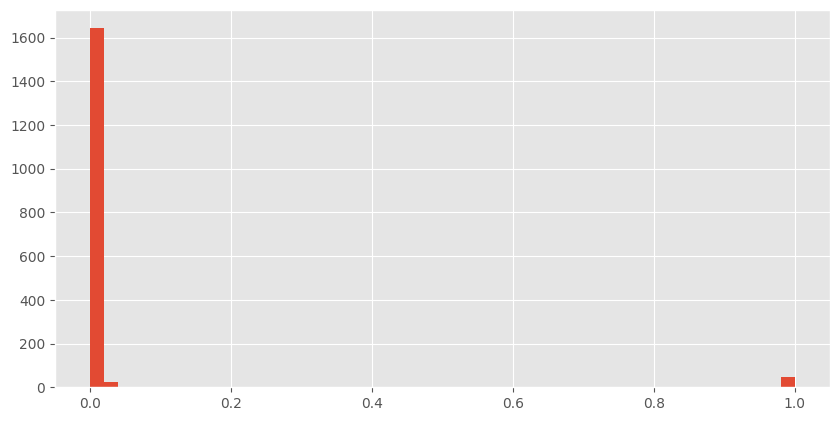

In [51]:
# Justifying application of 0.5 threshold.
plt.hist(train_pred_probabilities, bins=50)

In [40]:
## On test set
# Preprocess the test set
X_test, y_test = split_into_period_frames(prediction_period, test)
print(f"""After spliting:
The testing data includes {len(y_test)} frames, 
among which {sum(y_test)} are positive
""")
X_test, y_test = add_cases(prediction_period, test, X_test, y_test)
print(f"""After adding positive samples:
The testing data includes {len(y_test)} frames, 
among which {sum(y_test)} are positive
""")

print(f"In the testing set there are {round( (len(y_test)-sum(y_test)) / sum(y_test), 2)} times more negative samples than positive ones.")

After spliting:
The testing data includes 1696 frames, 
among which 14 are positive

After adding positive samples:
The testing data includes 1728 frames, 
among which 46 are positive

In the testing set there are 36.57 times more negative samples than positive ones.


In [41]:
#Make predictions
y_pred = model3.predict(X_test)
y_test_pred = [1 if y>0.5 else 0 for y in y_pred]

print('Test set confusion matrix:\n', confusion_matrix(y_test, y_test_pred))
print('Train set Precision: ', precision_score(y_test, y_test_pred))
print('Train set Recall: ', recall_score(y_test, y_test_pred))


54/54 [==============================] - 0s 6ms/step
Test set confusion matrix:
 [[1680    2]
 [   0   46]]
Train set Precision:  0.9583333333333334
Train set Recall:  1.0
